In [99]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [100]:
save = False

In [101]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [102]:
categories_control = ['original',
                      'length-control',
                      'constant-control']
                      

categories_scrambled = ['original',
                        'length-control',
                        'constant-control',
                        'scrambled1',
                        'scrambled3',
                        'scrambled5',
                        'scrambled7',
                        'backward',
                        'lowpmi',
                        'lowpmi-random',
                        'random-wl']

categories_perturb_loss = ['original',
                           'length-control',
                           'constant-control',
                           'nouns',
                           'nounsverbs',
                           'nounsverbsadj',
                           'contentwords',
                           'random-nouns',
                           'functionwords']

categories_perturb_meaning = ['sentenceshuffle_passage',
                              'sentenceshuffle_topic',
                              'sentenceshuffle_random']

categories_perturb = categories_perturb_loss + categories_perturb_meaning

categories = [categories_perturb, categories_scrambled, categories_control]
keys = ["perturb", "scrambled", "control"]

categories_dict = dict(zip(keys, categories))

# Get best model scores

In [103]:
def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error = 0,0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
    return max_score, error

In [104]:
# #not used currently
# def get_best_score_dict(model_identifier):
#     """
#     input: model_identifier
#     output: dictionary containing the maximum score and associated error per condition.
#             structure of dictionary: condition --> {score --> max_score, error --> associated error}
#     """
#     score_dict = {}
#     for filename in os.listdir(working_dir):
#         model_name = filename.split(",")[1]
#         if "model=" + model_identifier == model_name:
#             if ("-encoding-perturb" in filename) or ("encoding-scrambled" in filename):
#                 condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
#                 print(condition)
#                 if not condition in score_dict:
#                     score_dict[condition] = {}
#                 file = os.path.join(working_dir,filename)
#                 with open(file, 'rb') as f:
#                     out = pickle.load(f)
#                 result = out['data'].values
#                 #print(result, '\n\n')
#                 max_score, error = get_max_score(result)
#                 score_dict[condition]['score'] = max_score
#                 score_dict[condition]['error'] = error
#     return score_dict

In [105]:
def get_best_scores_df(model_identifier, categories_dict,
                       emb_context="Passage", split_coord="Sentence",
                       scr_perturb=None, testonperturbed=False):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    max_scores = []
    errors = []
    
    for filename in os.listdir(working_dir):
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
            
        if not testonperturbed:
            if "teston:" in filename:
                continue
        else:
            if not "teston:" in filename:
                continue
                
        if not f"emb_context={emb_context}" in filename:
            continue
                
        if not f"split_coord={split_coord}" in filename:
            continue            
                
        include_condition = False
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            
            if (f"-encoding-{scr_perturb}" in filename) or ("-encoding-scrambled-original" in filename):
                include_condition = True
            elif ("length-control" in filename) or ("constant-control" in filename):
                include_condition = True
            
            if include_condition == True:
#                 print(filename)
                condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
                
                if scr_perturb == "perturb":
                    condition = re.sub("perturb-","",condition)
                    condition = re.sub("scrambled-","",condition)
                    
                elif scr_perturb == "scrambled":
                    if not any(x in condition for x in ["1", "3", "5", "7"]):
                        condition = re.sub("scrambled-","",condition)
                    else:
                        condition = condition
                
                elif scr_perturb == "control":
                    condition = re.sub("scrambled-","",condition)

                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data'].values
                #print(result, '\n\n')
                max_score, error = get_max_score(result)
                
                conditions.append(condition)
                max_scores.append(max_score)
                errors.append(error)
                
    import pandas as pd
    index = conditions
    df = pd.DataFrame({'score': max_scores,
    'error': errors, 'condition': conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=categories_dict[scr_perturb])
    scores_df = df.sort_values(by='condition')
    return scores_df

In [106]:
# def get_last_scores_df(model_identifier):
#     """
#     input: model_identifier
#     output: dictionary containing the last score and associated error per condition.
#             structure of dictionary: condition --> {score --> max_score, error --> associated error}
#     """
#     conditions = []
#     last_scores = []
#     errors = []
#     for filename in os.listdir(working_dir):
#         model_name = filename.split(",")[1]
#         if "model=" + model_identifier == model_name:
#             if ("encoding-perturb" in filename) or ("encoding-scrambled" in filename):
#                 condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
#                 condition = re.sub("ablation-","",condition)
#                 condition = re.sub("scrambled-","",condition)

#                 file = os.path.join(working_dir,filename)
#                 with open(file, 'rb') as f:
#                     out = pickle.load(f)
#                 result = out['data'].values
#                 #print(result, '\n\n')
#                 last_score, error = last_score, error = result[-1][0], result[-1][1]
#                 conditions.append(condition)
#                 last_scores.append(last_score)
#                 errors.append(error)
#     import pandas as pd
#     index = conditions
#     df = pd.DataFrame({'score': last_scores,
#     'error': errors, 'condition': conditions})
#     df['condition'] = pd.Categorical(df['condition'], categories=['original', 'nouns', 'nounsverbs', 'nounsverbsadj', 'contentwords', 'functionwords', 'passageshuffle','nouns-delete50percent','random-lowPMI','random-nouns'])
#     #df['condition'] = pd.Categorical(df['condition'], categories=['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random'])
#     scores_df = df.sort_values(by='condition')
#     return scores_df

In [107]:
#function check
scores_df = get_best_scores_df("distilgpt2",categories_dict,scr_perturb="control")
scores_df

,score,error,condition
2,0.871620,0.077534,original
1,0.058070,0.095018,length-control
0,0.169302,0.112546,constant-control


In [108]:
#function check
scores_df = get_best_scores_df("distilgpt2",categories_dict,scr_perturb="scrambled")
scores_df

,score,error,condition
5,0.871620,0.077534,original
1,0.058070,0.095018,length-control
0,0.169302,0.112546,constant-control
7,0.876199,0.043466,scrambled1
8,0.876261,0.038490,scrambled3
9,0.860827,0.048159,scrambled5
10,0.884308,0.093576,scrambled7
2,0.795170,0.074308,backward
3,0.884736,0.096202,lowpmi
4,0.849663,0.091064,lowpmi-random


In [109]:
#function check
scores_df = get_best_scores_df("distilgpt2",categories_dict,scr_perturb="perturb")
scores_df

,score,error,condition
11,0.871620,0.077534,original
1,0.058070,0.095018,length-control
0,0.169302,0.112546,constant-control
4,0.772000,0.118059,nouns
5,0.832689,0.129917,nounsverbs
6,0.815670,0.166101,nounsverbsadj
2,0.847025,0.121691,contentwords
7,0.708768,0.111683,random-nouns
3,0.493653,0.063573,functionwords
8,0.847901,0.076104,sentenceshuffle_passage


# Prepare plotting

In [110]:
def bar_plot(model_identifier, scores_df, scr_perturb=None):
    colors = sns.color_palette("rocket")
    x_pos = np.arange(len(scores_df))
    scores = scores_df['score']
    errors = scores_df['error']
    conditions = scores_df['condition']
    
    print(np.unique(list(conditions)))
    
    # abbreviate condition names for perturb
    new_conditions = []
    for elm in conditions:
        if "sentenceshuffle_random" in elm:
            elm = re.sub("sentenceshuffle_random","sent_random",elm)
        if elm == "sentenceshuffle_passage":
            elm = re.sub("sentenceshuffle_passage","sent_passage",elm)
        if elm == "sentenceshuffle_topic":
            elm = re.sub("sentenceshuffle_topic","sent_topic",elm)
        new_conditions.append(elm)
    conditions = new_conditions
    
    fig, ax = plt.subplots()
    ax.bar(x_pos, scores,
       yerr=errors,
       align='center',
       alpha=0.8, #color intensity
       ecolor='black',
       capsize=5, #error bar width
       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
    ax.set_ylabel('ceiled score',fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(conditions, rotation=90)
    
    if len(model_identifier.split("-")) == 1:
        model_identifier += "-lasttoken"
    ax.set_title('{}'.format(model_identifier),fontsize=18)
    ax.yaxis.grid(True)
    if not model_identifier == "gpt2-xl":
        ax.set_ylim([0,1])
    else:
        ax.set_ylim([0,1.5])
    
    if not os.path.isdir("fig_june2022"):
        os.mkdir("fig_june2022")
    if save:
        savename = f'fig_june2022/match-to-brain_{scr_perturb}_{model_identifier}.png'
        plt.savefig(savename, bbox_inches='tight', dpi=240)
    plt.show()

In [111]:
def main_plot(model_identifier,categories_dict,scr_perturb="scrambled"):
    scores_df = get_best_scores_df(model_identifier,categories_dict,scr_perturb=scr_perturb)
    bar_plot(model_identifier,scores_df,scr_perturb=scr_perturb)

# Ready to plot!

In [112]:
# main_plot('distilgpt2',categories_dict,scr_perturb="control")
# main_plot('distilgpt2',categories_dict,scr_perturb="scrambled")
# main_plot('distilgpt2',categories_dict,scr_perturb="perturb")

In [113]:
# main_plot('distilgpt2-avgtoken',categories_dict,scr_perturb="control")
# main_plot('distilgpt2-avgtoken',categories_dict,scr_perturb="scrambled")
# main_plot('distilgpt2-avgtoken',categories_dict,scr_perturb="perturb")

In [114]:
# main_plot('gpt2-xl',categories_dict,scr_perturb="control")
# main_plot('gpt2-xl',categories_dict,scr_perturb="scrambled")
# main_plot('gpt2-xl',categories_dict,scr_perturb="perturb")

# Passagesplit

In [115]:
#get_best_scores_df(model_identifier, categories_dict,
#                   emb_context="Passage", split_coord="Sentence",
#                   scr_perturb=None, testonperturbed=False)

def main_plot_passagesplit(model_identifier,categories_dict,scr_perturb=None):
    scores_df = get_best_scores_df(model_identifier,categories_dict,scr_perturb=scr_perturb, split_coord="Passage")
    bar_plot(model_identifier,scores_df,scr_perturb=scr_perturb)

In [116]:
# main_plot_passagesplit('distilgpt2',categories_dict,scr_perturb="control")

In [117]:
# main_plot_passagesplit('distilgpt2',categories_dict,scr_perturb="scrambled")
# main_plot_passagesplit('distilgpt2',categories_dict,scr_perturb="perturb")

In [118]:
# main_plot_passagesplit('distilgpt2-avgtoken',categories_dict,scr_perturb="scrambled")
# main_plot_passagesplit('distilgpt2-avgtoken',categories_dict,scr_perturb="perturb")

In [119]:
# main_plot_passagesplit('gpt2-xl',categories_dict,scr_perturb="scrambled")
# main_plot_passagesplit('gpt2-xl',categories_dict,scr_perturb="perturb")

In [120]:
# main_plot_passagesplit('distilgpt2-untrained',categories_dict,scr_perturb="scrambled")

# Decontextualized

In [121]:
#get_best_scores_df(model_identifier, categories_dict,
#                   emb_context="Passage", split_coord="Sentence",
#                   scr_perturb=None, testonperturbed=False)

def main_plot_decontextualized(model_identifier,categories_dict,scr_perturb=None):
    scores_df = get_best_scores_df(model_identifier,categories_dict,scr_perturb=scr_perturb, emb_context="Sentence")
    bar_plot(model_identifier,scores_df,scr_perturb=scr_perturb)

In [122]:
# main_plot_decontextualized('distilgpt2',categories_dict,scr_perturb="scrambled")
# main_plot_decontextualized('distilgpt2',categories_dict,scr_perturb="perturb")

In [123]:
# main_plot_decontextualized('distilgpt2-avgtoken',categories_dict,scr_perturb="scrambled")
# main_plot_decontextualized('distilgpt2-avgtoken',categories_dict,scr_perturb="perturb")

In [124]:
# #NOT RUN YET! perturbed-neural-nlp/bash_paper/gpt2xl_decont.sh
# main_plot_decontextualized('gpt2-xl',categories_dict,scr_perturb="scrambled")
# main_plot_decontextualized('gpt2-xl',categories_dict,scr_perturb="perturb")

# Test on perturbed

In [125]:
teston_categories_control = ['teston:original',
                      'teston:length-control',
                      'teston:constant-control']
                      

teston_categories_scrambled = ['teston:original',
                        'teston:length-control',
                        'teston:constant-control',
                        'teston:scr1',
                        'teston:scr3',
                        'teston:scr5',
                        'teston:scr7',
                        'teston:backward',
                        'teston:lowpmi',
                        'teston:lowpmi-random',
                        'teston:random-wl']

teston_categories_perturb_loss = ['teston:original',
                           'teston:length-control',
                           'teston:constant-control',
                           'teston:nouns',
                           'teston:nounsverbs',
                           'teston:nounsverbsadj',
                           'teston:contentwords',
                           'teston:random-nouns',
                           'teston:functionwords']

teston_categories_perturb_meaning = ['teston:sentenceshuffle_passage',
                              'teston:sentenceshuffle_topic',
                              'teston:sentenceshuffle_random']

teston_categories_perturb = teston_categories_perturb_loss + teston_categories_perturb_meaning

categories = [teston_categories_perturb, teston_categories_scrambled, teston_categories_control]
keys = ["perturb", "scrambled", "control"]

categories_dict_teston = dict(zip(keys, categories))

In [126]:
def get_best_scores_df_testonperturbed(model_identifier, categories_dict_teston,
                       emb_context="Passage", split_coord="Sentence",
                       scr_perturb=None):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    max_scores = []
    errors = []
    
    for filename in os.listdir(working_dir):
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
            
        if not any(x in filename for x in categories_dict_teston[scr_perturb]):
            continue
                
        if not f"emb_context={emb_context}" in filename:
            continue
                
        if not f"split_coord={split_coord}" in filename:
            continue     
                
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
#             print(filename)
            condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
#             print(condition)

            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data'].values
            #print(result, '\n\n')
            max_score, error = get_max_score(result)

            conditions.append(condition)
            max_scores.append(max_score)
            errors.append(error)
                
    import pandas as pd
    index = conditions
    df = pd.DataFrame({'score': max_scores,
    'error': errors, 'condition': conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=categories_dict_teston[scr_perturb])
    scores_df = df.sort_values(by='condition').reset_index(drop=True)
    return scores_df

In [127]:
scores_df = get_best_scores_df_testonperturbed("distilgpt2", categories_dict_teston, scr_perturb="control")
scores_df

,score,error,condition
0,0.871697,0.079766,teston:original
1,0.092608,0.120363,teston:length-control
2,0.027754,0.127978,teston:constant-control


In [128]:
def bar_plot(model_identifier, scores_df, scr_perturb=None):
    colors = sns.color_palette("rocket")
    x_pos = np.arange(len(scores_df))
    scores = scores_df['score']
    errors = scores_df['error']
    conditions = scores_df['condition']
    
    print(np.unique(list(conditions)))
    
    # abbreviate condition names for perturb
    new_conditions = []
    for elm in conditions:
        if "sentenceshuffle_random" in elm:
            elm = re.sub("sentenceshuffle_random","sent_random",elm)
        if "sentenceshuffle_passage" in elm:
            elm = re.sub("sentenceshuffle_passage","sent_passage",elm)
        if "sentenceshuffle_topic" in elm:
            elm = re.sub("sentenceshuffle_topic","sent_topic",elm)
        new_conditions.append(elm)
    conditions = new_conditions
    
    fig, ax = plt.subplots()
    ax.bar(x_pos, scores,
       yerr=errors,
       align='center',
       alpha=0.8, #color intensity
       ecolor='black',
       capsize=5, #error bar width
       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
    ax.set_ylabel('ceiled score',fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(conditions, rotation=90)
    
    if len(model_identifier.split("-")) == 1:
        model_identifier += "-lasttoken"
    ax.set_title('{}'.format(model_identifier),fontsize=18)
    ax.yaxis.grid(True)
    ax.set_ylim([0,1])
    
    if not os.path.isdir("fig_june2022"):
        os.mkdir("fig_june2022")
    if save:
        savename = f'fig_june2022/match-to-brain_teston:{scr_perturb}_{model_identifier}.png'
        plt.savefig(savename, bbox_inches='tight', dpi=240)
    plt.show()

In [129]:
#get_best_scores_df(model_identifier, categories_dict,
#                   emb_context="Passage", split_coord="Sentence",
#                   scr_perturb=None, testonperturbed=False)

def main_plot_testonperturbed(model_identifier,categories_dict_teston,split_coord="Sentence", scr_perturb=None):
    scores_df = get_best_scores_df_testonperturbed(model_identifier,categories_dict_teston,split_coord=split_coord,
                                                   scr_perturb=scr_perturb)
    bar_plot(model_identifier,scores_df,scr_perturb=scr_perturb)

In [130]:
# main_plot_testonperturbed('distilgpt2',categories_dict_teston,scr_perturb="control")
# main_plot_testonperturbed('distilgpt2',categories_dict_teston,scr_perturb="scrambled")
# main_plot_testonperturbed('distilgpt2',categories_dict_teston,scr_perturb="perturb")

In [131]:
# main_plot_testonperturbed('distilgpt2',categories_dict_teston,split_coord="Passage", scr_perturb="control")
# main_plot_testonperturbed('distilgpt2',categories_dict_teston,split_coord="Passage", scr_perturb="scrambled")
# main_plot_testonperturbed('distilgpt2',categories_dict_teston,split_coord="Passage", scr_perturb="perturb")

In [132]:
# main_plot_testonperturbed('distilgpt2-avgtoken',categories_dict_teston,scr_perturb="control")
# main_plot_testonperturbed('distilgpt2-avgtoken',categories_dict_teston,scr_perturb="scrambled")
# main_plot_testonperturbed('distilgpt2-avgtoken',categories_dict_teston,scr_perturb="perturb")

In [133]:
# main_plot_testonperturbed('gpt2-xl',categories_dict_teston,scr_perturb="control")
# main_plot_testonperturbed('gpt2-xl',categories_dict_teston,scr_perturb="scrambled")
# main_plot_testonperturbed('gpt2-xl',categories_dict_teston,scr_perturb="perturb")

In [134]:
#get_best_scores_df(model_identifier, categories_dict,
#                   emb_context="Passage", split_coord="Sentence",
#                   scr_perturb=None, testonperturbed=False)

def main_plot_testonperturbed_passagesplit(model_identifier,categories_dict_teston,split_coord="Passage", scr_perturb=None):
    scores_df = get_best_scores_df_testonperturbed(model_identifier,categories_dict_teston,split_coord=split_coord,
                                                   scr_perturb=scr_perturb)
    bar_plot(model_identifier,scores_df,scr_perturb=scr_perturb)

['teston:constant-control' 'teston:length-control' 'teston:original']


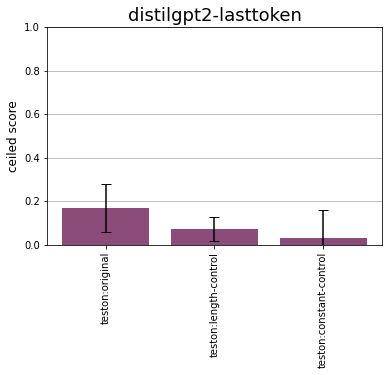

['teston:backward' 'teston:constant-control' 'teston:length-control'
 'teston:lowpmi' 'teston:lowpmi-random' 'teston:original'
 'teston:random-wl' 'teston:scr1' 'teston:scr3' 'teston:scr5'
 'teston:scr7']


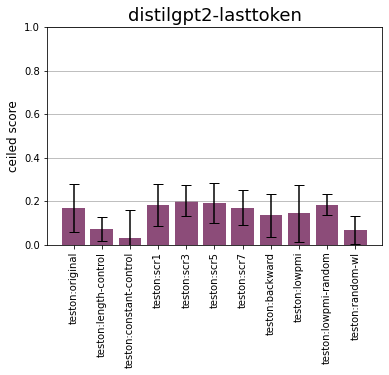

['teston:constant-control' 'teston:contentwords' 'teston:functionwords'
 'teston:length-control' 'teston:nouns' 'teston:nounsverbs'
 'teston:nounsverbsadj' 'teston:original' 'teston:random-nouns'
 'teston:sentenceshuffle_passage' 'teston:sentenceshuffle_random'
 'teston:sentenceshuffle_topic']


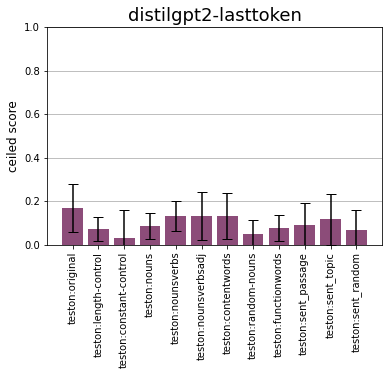

In [135]:
main_plot_testonperturbed_passagesplit('distilgpt2',categories_dict_teston,scr_perturb="control")
main_plot_testonperturbed_passagesplit('distilgpt2',categories_dict_teston,scr_perturb="scrambled")
main_plot_testonperturbed_passagesplit('distilgpt2',categories_dict_teston,scr_perturb="perturb")

# Loop into subplots

In [136]:
import math
from matplotlib.gridspec import GridSpec

def get_subplots_loop(model_list, scr_perturb=None):
    nsubplots = len(model_list) * 4 #original, decontextualized, passagesplit, teston:perturbed
    nrows = math.ceil(nsubplots/2)
    colors = sns.color_palette("rocket")
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 6*nrows))
    fig2.suptitle('{}'.format(scr_perturb), fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    counter = 0
    for i in range(nrows):
        for j in range(2):
            if counter + 1 > nsubplots:
                break
            else:
                model_name = model_list[counter % len(model_list)]
                print(model_name)
                
                if i%4 == 0:
                    scores_df = get_best_scores_df(model_name,categories_dict,scr_perturb=scr_perturb)
                    title_addition = ""
                elif i%3 == 0:
                    scores_df = get_best_scores_df_testonperturbed(model_name, categories_dict_teston,scr_perturb=scr_perturb)
                    title_addition = " | teston:perturbed"
                elif i%2 == 0:
                    scores_df =  get_best_scores_df(model_name, categories_dict,scr_perturb=scr_perturb, split_coord="Passage")
                    title_addition = " | split_coord = Passage"
                elif i%1 == 0:
                    scores_df =  get_best_scores_df(model_name, categories_dict,scr_perturb=scr_perturb, emb_context="Sentence")
                    title_addition = " | decontextualized"
#                 print(scores_df.head())

                x_pos = np.arange(len(scores_df))
                scores = scores_df['score']
                errors = scores_df['error']
                conditions = scores_df['condition']
                
                # abbreviate condition names for perturb
                new_conditions = []
                for elm in conditions:
                    if "sentenceshuffle_random" in elm:
                        elm = re.sub("sentenceshuffle_random","sent_random",elm)
                    if elm == "sentenceshuffle_passage":
                        elm = re.sub("sentenceshuffle_passage","sent_passage",elm)
                    if elm == "sentenceshuffle_topic":
                        elm = re.sub("sentenceshuffle_topic","sent_topic",elm)
                    new_conditions.append(elm)
                conditions = new_conditions

                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                
                #set colors: 1*original, 2*control, 7* information loss manipulation, rest: sentence meaning manipulation
                if scr_perturb == "perturb":
                    curr_colors = [colors[1]] + [colors[3]]*(len(conditions)-4) + [colors[4]]*3
                elif scr_perturb == "scrambled":
                    #set colors: 1*original, 2*control, rest: word-order manipulations
                    curr_colors = [colors[1]] + [colors[2]]*(len(conditions)-1)
                elif scr_perturb == "control":
                    curr_colors = [colors[1]] + [colors[2]]*(len(conditions)-1)
                else:
                    print("scr_perturb condition not defined!")
                f2_ax[-1].bar(x_pos, scores,
                       yerr=errors,
                       align='center',
                       alpha=0.8, #color intensity
                       ecolor='black',
                       capsize=5, #error-bar width
                       color=curr_colors)#colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
                f2_ax[-1].set_ylabel('ceiled score',fontsize=12)
                f2_ax[-1].set_xticks(x_pos)
                f2_ax[-1].set_xticklabels(conditions, rotation=90)
                                                               
                if model_name != "gpt2-xl":
                    f2_ax[-1].set_ylim([0, 1])
                else:
                    f2_ax[-1].set_ylim([0, 1.5])
                                                            

                if len(model_name.split("-")) == 1:
                    model_name = model_name + "-lasttoken"
                f2_ax[-1].set_title('{}{}'.format(model_name,title_addition),fontsize=18)
                f2_ax[-1].yaxis.grid(True)
                counter += 1
                
    if save:
        fig2.savefig(f'fig/match-to-brain_loop_{scr_perturb}.png', bbox_inches='tight', dpi=240)

distilgpt2
distilgpt2-avgtoken
distilgpt2
distilgpt2-avgtoken
distilgpt2
distilgpt2-avgtoken
distilgpt2
distilgpt2-avgtoken


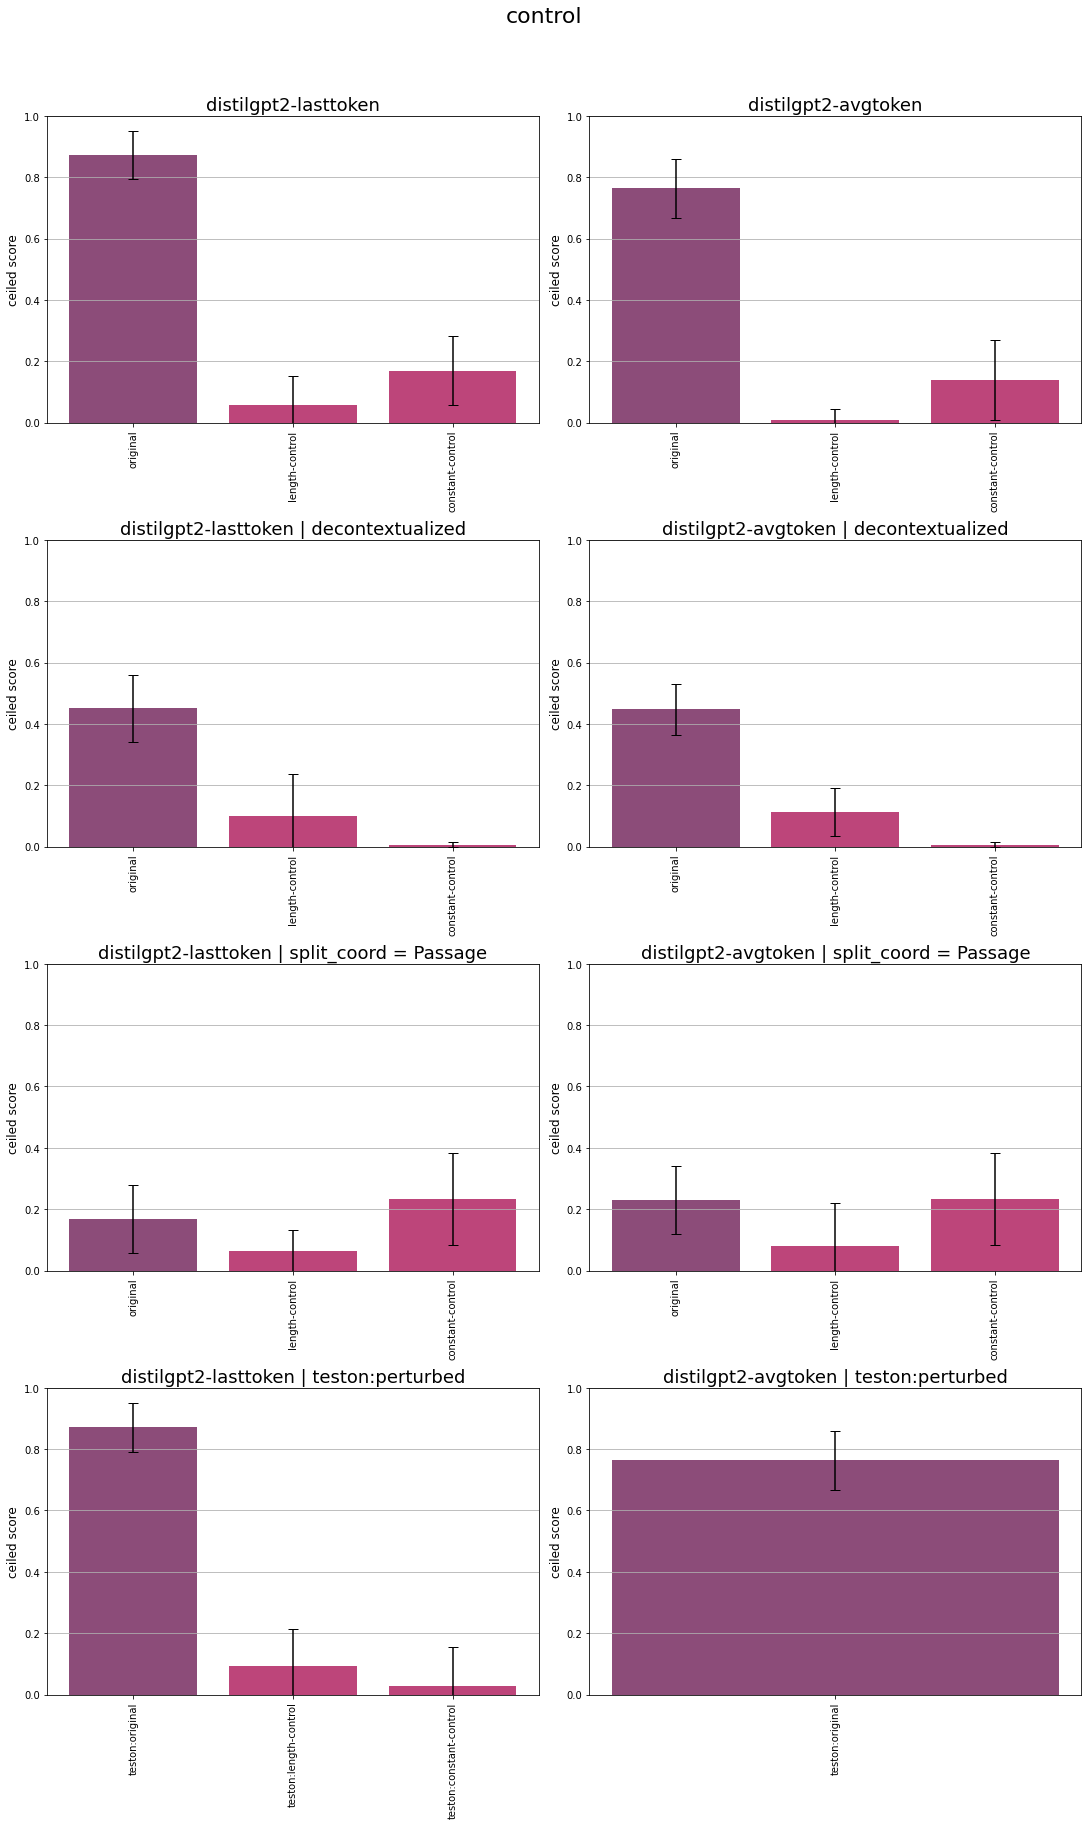

In [137]:
get_subplots_loop(['distilgpt2', 'distilgpt2-avgtoken'], scr_perturb="control")

distilgpt2
distilgpt2-avgtoken
distilgpt2
distilgpt2-avgtoken
distilgpt2
distilgpt2-avgtoken
distilgpt2
distilgpt2-avgtoken


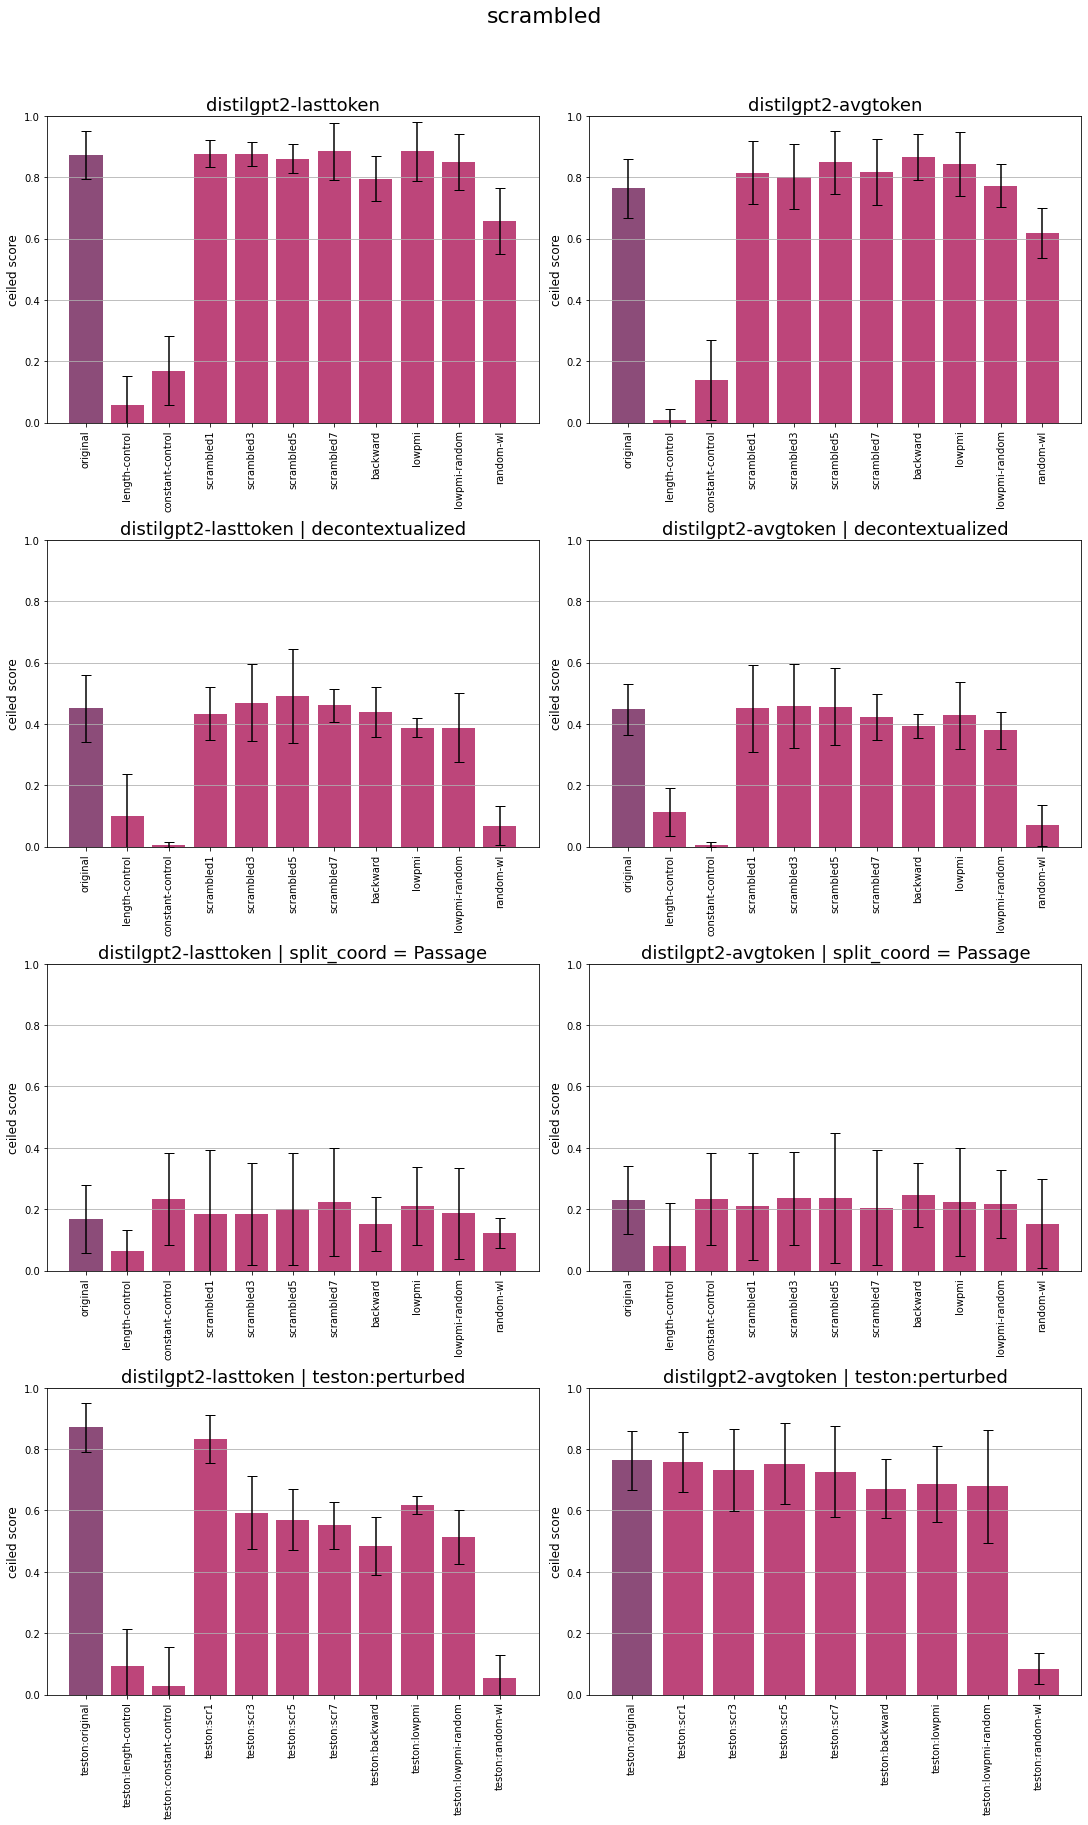

In [138]:
get_subplots_loop(['distilgpt2', 'distilgpt2-avgtoken'], scr_perturb="scrambled")

distilgpt2
distilgpt2-avgtoken
distilgpt2
distilgpt2-avgtoken
distilgpt2
distilgpt2-avgtoken
distilgpt2
distilgpt2-avgtoken


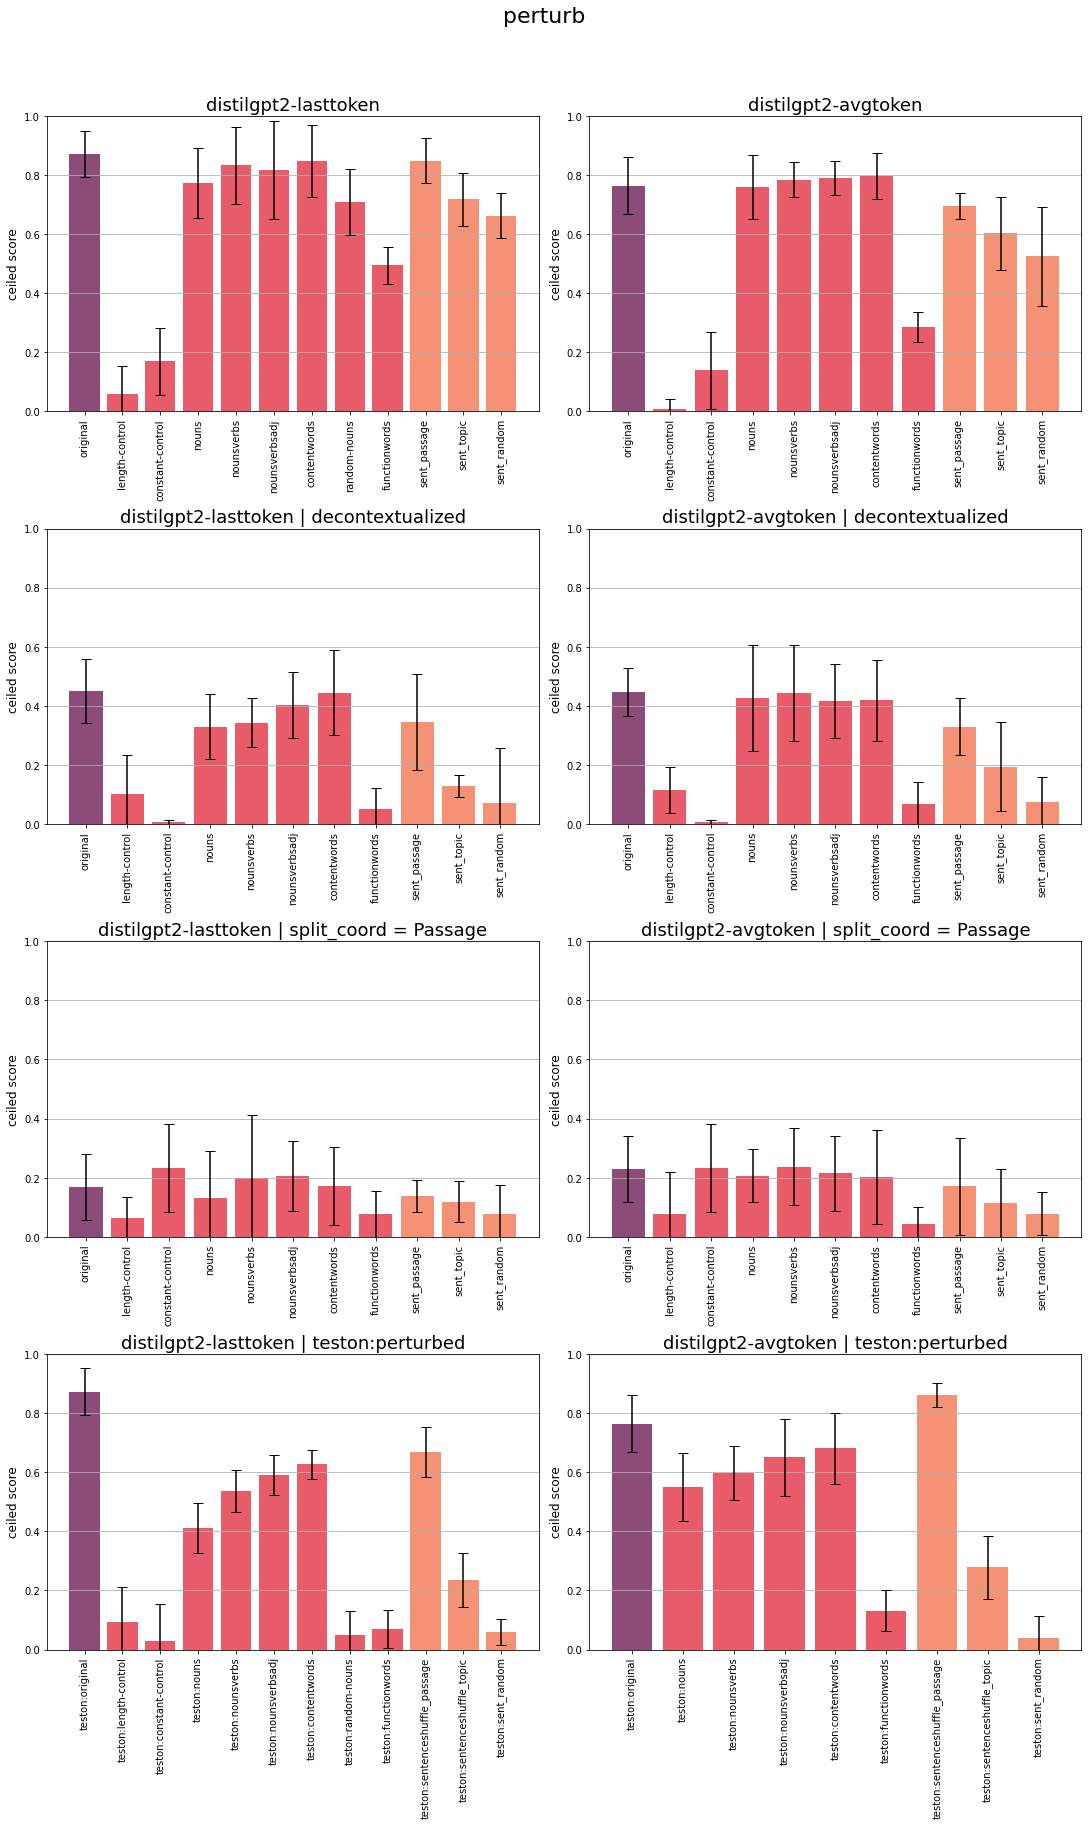

In [139]:
get_subplots_loop(['distilgpt2', 'distilgpt2-avgtoken'], scr_perturb="perturb")

['original' 'random-wl']


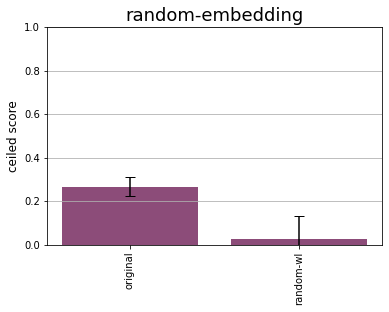

In [140]:
main_plot('random-embedding',categories_dict,scr_perturb="scrambled")

['original' 'random-wl']


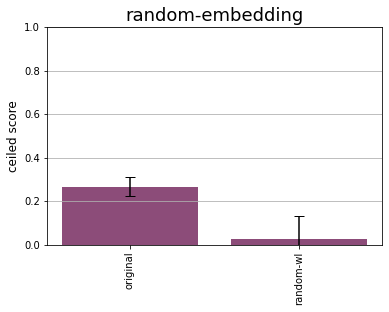

In [141]:
main_plot_decontextualized('random-embedding',categories_dict,scr_perturb="scrambled")

['original' 'random-wl']


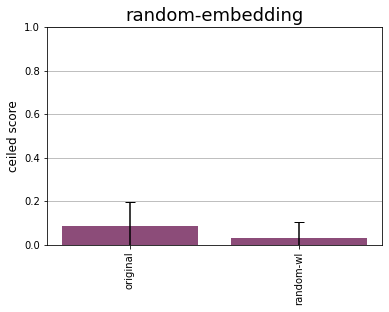

In [142]:
main_plot_passagesplit('random-embedding',categories_dict,scr_perturb="scrambled")

['original' 'random-wl']


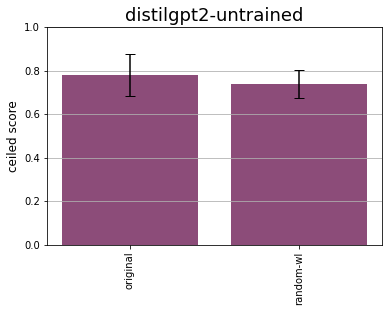

In [143]:
main_plot('distilgpt2-untrained',categories_dict,scr_perturb="scrambled")

['original' 'random-wl']


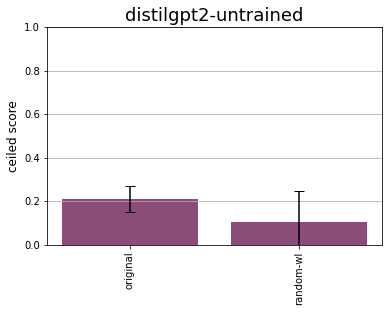

In [144]:
main_plot_decontextualized('distilgpt2-untrained',categories_dict,scr_perturb="scrambled")

['original' 'random-wl']


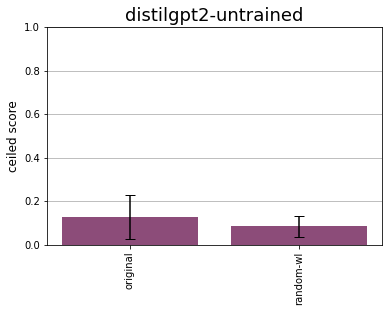

In [145]:
main_plot_passagesplit('distilgpt2-untrained',categories_dict,scr_perturb="scrambled")

gpt2
gpt2-xl
gpt2
gpt2-xl
gpt2
gpt2-xl
gpt2
gpt2-xl


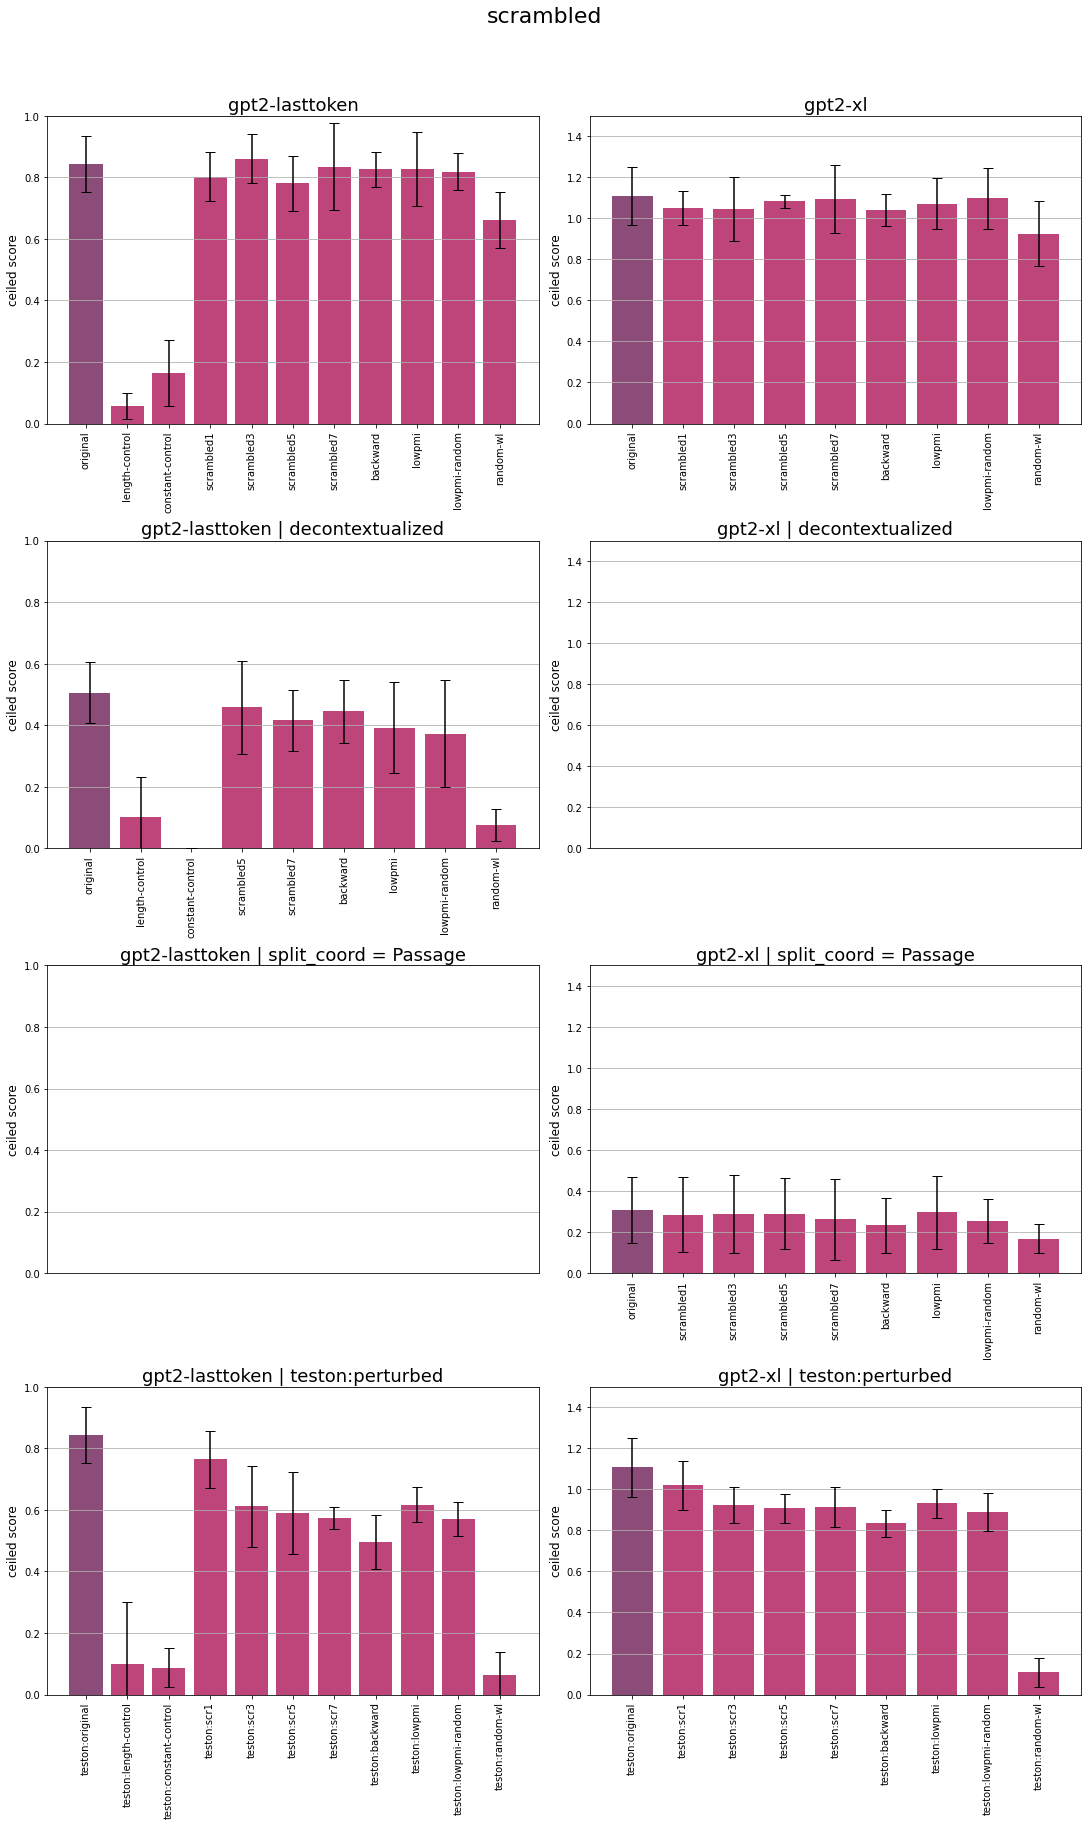

In [146]:
get_subplots_loop(['gpt2','gpt2-xl'], scr_perturb="scrambled")

gpt2
gpt2-xl
gpt2
gpt2-xl
gpt2
gpt2-xl
gpt2
gpt2-xl


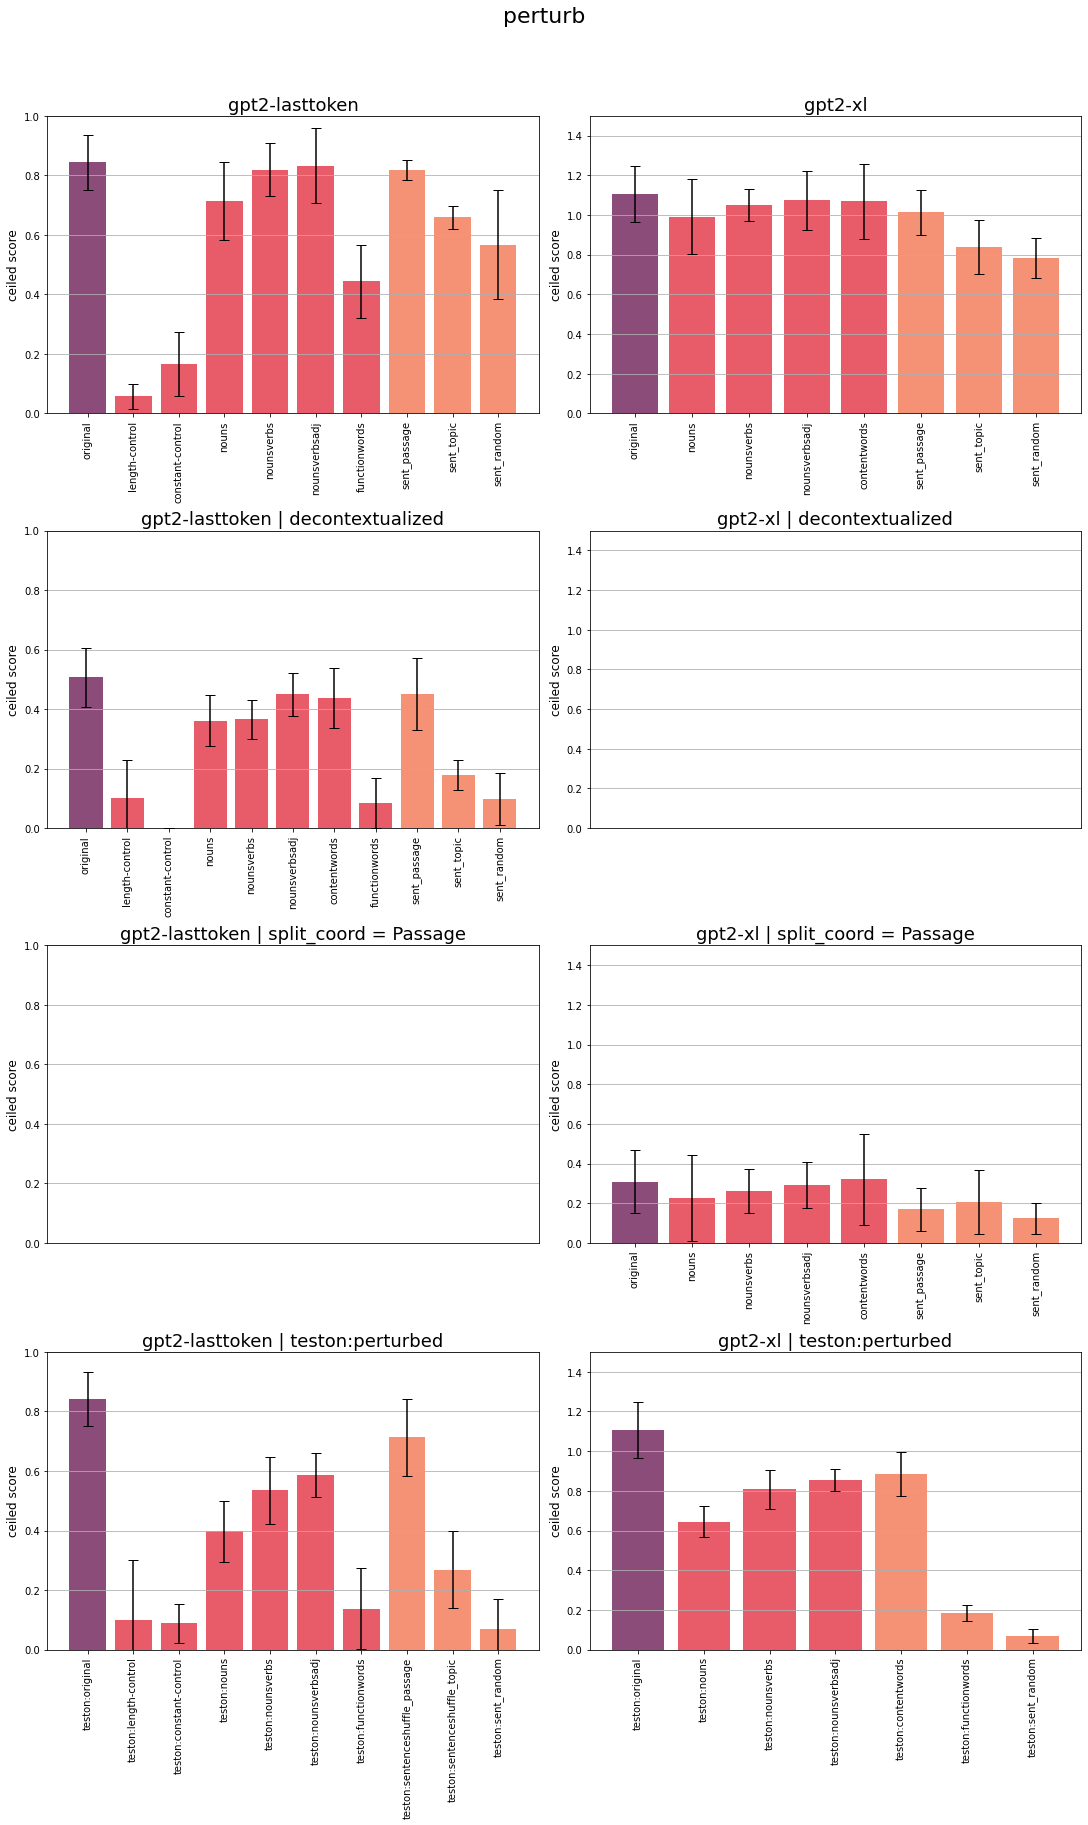

In [147]:
get_subplots_loop(['gpt2','gpt2-xl'], scr_perturb="perturb")